In [9]:
!git remote add https://github.com/Ray16/AI_Hackathon_Team_borides_Challenge_I.git 

usage: git remote add [<options>] <name> <url>

    -f, --fetch           fetch the remote branches
    --tags                import all tags and associated objects when fetching
                          or do not fetch any tag at all (--no-tags)
    -t, --track <branch>  branch(es) to track
    -m, --master <branch>
                          master branch
    --mirror[=(push|fetch)]
                          set up remote as a mirror to push to or fetch from



In [6]:
!git push --set-upstream origin master

fatal: unable to access 'https://github.com/Ray16/AI_Hackathon_Team_borides_Challenge_I.git/': Couldn't connect to server


# Generate 8-channel Features

In [39]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

#load dataset
data = 'D' # specify dataset (A / B / C / D)
dataset = pd.read_csv(f'./data/data_{data}.csv')
dataset_name='dataSet'+data

## Generate sliding window

In [71]:
all_windows=[]
min_window = 2 # minimum window size
max_window = 5 # maximum window size
for window_size in range(min_window,max_window+1):
    step=1
    ranges = [range(2)]*window_size
    windows=[]
    for xs in itertools.product(*ranges):
        windows.append([*xs])
    all_windows.append(windows)
    print(f'generating features with window size {window_size}...')
    for window in windows:
        print(f'window:{window}')
        sliding_activation=[]
        for line_n in range(len(dataset)):
            line = list(dataset.iloc[line_n,:])
            region_activation = []
            for start in range(32-window_size):
                region = list(dataset.iloc[:,1:-1].iloc[line_n,start:start+window_size])
                if region == window:
                    region_activation.append(1)
                else:
                    region_activation.append(0)
                start+=step
            sliding_activation.append(region_activation)
        pd.DataFrame(sliding_activation).to_csv(f'./features/window_size_{window_size}_window_{window}.csv',index=False)

generating features with window size 2...
window:[0, 0]
window:[0, 1]
window:[1, 0]
window:[1, 1]
generating features with window size 3...
window:[0, 0, 0]
window:[0, 0, 1]
window:[0, 1, 0]
window:[0, 1, 1]
window:[1, 0, 0]
window:[1, 0, 1]
window:[1, 1, 0]
window:[1, 1, 1]
generating features with window size 4...
window:[0, 0, 0, 0]
window:[0, 0, 0, 1]
window:[0, 0, 1, 0]
window:[0, 0, 1, 1]
window:[0, 1, 0, 0]
window:[0, 1, 0, 1]
window:[0, 1, 1, 0]
window:[0, 1, 1, 1]
window:[1, 0, 0, 0]
window:[1, 0, 0, 1]
window:[1, 0, 1, 0]
window:[1, 0, 1, 1]
window:[1, 1, 0, 0]
window:[1, 1, 0, 1]
window:[1, 1, 1, 0]
window:[1, 1, 1, 1]
generating features with window size 5...
window:[0, 0, 0, 0, 0]
window:[0, 0, 0, 0, 1]
window:[0, 0, 0, 1, 0]
window:[0, 0, 0, 1, 1]
window:[0, 0, 1, 0, 0]
window:[0, 0, 1, 0, 1]
window:[0, 0, 1, 1, 0]
window:[0, 0, 1, 1, 1]
window:[0, 1, 0, 0, 0]
window:[0, 1, 0, 0, 1]
window:[0, 1, 0, 1, 0]
window:[0, 1, 0, 1, 1]
window:[0, 1, 1, 0, 0]
window:[0, 1, 1, 0, 1

In [73]:
# combine features
print(f'combining features ...')

for i, window_size in enumerate(range(min_window,max_window+1)):
    windows = all_windows[i]
    df_all = []
    for col in range(32-window_size):
        all_column=[]
        for window in windows:
            column = list(pd.read_csv(f'./features/window_size_{window_size}_window_{window}.csv').iloc[:,col])
            all_column.append(column)
        df_all.append(list(zip(*all_column)))
    
    #save data
    transpose_m = np.transpose(np.array(df_all),(1,0,2))
    df_save = np.reshape(transpose_m,(len(transpose_m), -1))
    np.savetxt(f"./features/sliding_window_{window_size}.txt",df_save)
print('done')

combining features ...
done


# multi-channel 1D CNN

In [74]:
from keras.models import Sequential
from keras import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, Flatten, Concatenate, Input

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [75]:
#load kernels
kernel_matrix=[]
kernels = open(f'./features/{dataset_name}.kern').readlines()
for i in range(len(kernels)):
    kernel = [float(i) for i in kernels[i].strip().split()]
    kernel_matrix.append(kernel)

#load data

window_size = 5 # specify window size

n_channel = 2**window_size

X = np.loadtxt(f"./features/sliding_window_{window_size}.txt")
X = X.reshape(X.shape[0], X.shape[1] // n_channel , n_channel)
interaction_param, y = dataset['interaction_parameter'], dataset['lamellar_period']

In [76]:
# split train / test set
train_idx = np.random.choice(range(len(X)), size=int(0.8*(len(X))), replace=False)
X_train = X[train_idx]
y_train = np.array([y[i] for i in train_idx])

test_idx = list(set(range(len(X)))-set(train_idx))
X_test = X[test_idx]
y_test = np.array([y[i] for i in test_idx])

#interaction_kernel
interaction_kernel_train = np.array([[interaction_param[i]]+kernel_matrix[i] for i in train_idx])
interaction_kernel_test = np.array([[interaction_param[i]]+kernel_matrix[i] for i in test_idx])

In [83]:
# inputs to ONLY FC layers
global auxInputDim
auxInputDim = 46
input_b = Input(shape=(auxInputDim))

# Standard 32-length vec input
input = Input(shape =(32-window_size,n_channel)) # 1st Conv Block

# Model definition
x = Conv1D(29, 2, activation="relu", input_shape=(29,n_channel))(input)
x = Flatten()(x)

# add inputs to FC layers
x = Concatenate()([x,input_b])
x = Flatten()(x)

x = Dense(units = 300, activation ='relu')(x)
x = Dense(units = 64+auxInputDim, activation ='relu')(x)

regression = Dense(units = 1, activation='relu', name='regression')(x)

# final model
model = Model(inputs=[input,input_b], outputs=regression) # {'regression':regression}

model.compile(loss='mse', optimizer=Adam(), metrics=['mse'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 27, 32)]     0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 26, 29)       1885        ['input_16[0][0]']               
                                                                                                  
 flatten_14 (Flatten)           (None, 754)          0           ['conv1d_7[0][0]']               
                                                                                                  
 input_15 (InputLayer)          [(None, 46)]         0           []                               
                                                                                            

In [ ]:
# model training
epochs = 500
model.fit([X_train, interaction_kernel_train], y_train, batch_size=12,epochs=epochs, verbose=1)

Epoch 1/500
75/75 [==============================] - 0s 2ms/step - loss: 20.1910 - mse: 20.1910
Epoch 2/500
75/75 [==============================] - 0s 1ms/step - loss: 0.3611 - mse: 0.3611
Epoch 3/500
75/75 [==============================] - 0s 1ms/step - loss: 0.1540 - mse: 0.1540
Epoch 4/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0848 - mse: 0.0848
Epoch 5/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0605 - mse: 0.0605
Epoch 6/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0451 - mse: 0.0451
Epoch 7/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0403 - mse: 0.0403
Epoch 8/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0317 - mse: 0.0317
Epoch 9/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0269 - mse: 0.0269
Epoch 10/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0233 - mse: 0.0233
Epoch 11/500
75/75 [==============================] - 0s 

75/75 [==============================] - 0s 2ms/step - loss: 0.0073 - mse: 0.0073
Epoch 173/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0090 - mse: 0.0090
Epoch 174/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0081 - mse: 0.0081
Epoch 175/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0109 - mse: 0.0109
Epoch 176/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0153 - mse: 0.0153
Epoch 177/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0131 - mse: 0.0131
Epoch 178/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0275 - mse: 0.0275
Epoch 179/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0278 - mse: 0.0278
Epoch 180/500
75/75 [==============================] - 0s 2ms/step - loss: 0.0151 - mse: 0.0151
Epoch 181/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0134 - mse: 0.0134
Epoch 182/500
75/75 [==============================] -

75/75 [==============================] - 0s 1ms/step - loss: 0.0050 - mse: 0.0050
Epoch 343/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0046 - mse: 0.0046
Epoch 344/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0054 - mse: 0.0054
Epoch 345/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0082 - mse: 0.0082
Epoch 346/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0040 - mse: 0.0040
Epoch 347/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0030 - mse: 0.0030
Epoch 348/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0200 - mse: 0.0200
Epoch 349/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0084 - mse: 0.0084
Epoch 350/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0096 - mse: 0.0096
Epoch 351/500
75/75 [==============================] - 0s 1ms/step - loss: 0.0173 - mse: 0.0173
Epoch 352/500
75/75 [==============================] -

In [ ]:
#make prediction
ypred_test = model.predict([X_test, interaction_kernel_test])
model_mse = mean_squared_error(y_test, ypred_test)
print("MSE: %.4f" % model_mse)

In [ ]:
# calc R^2
correlation_matrix = np.corrcoef(ypred_test.flatten(), y_test)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
ax = fig.add_subplot(111)

plt.title(f'MSE = {model_mse:.4f}.  Epochs = {epochs}.  R^2 = {r_squared:.4f}') # MSE
plt.scatter(ypred_test, y_test, s=5, color="blue") # x_axis, y_axis, ...
plt.xlabel("Predicted")
plt.ylabel("Actual")

# plot y = x
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# plt.aspect('equal')
plt.xlim(lims)
plt.ylim(lims)

## Sliding window (size 4)

In [16]:
windows_4=[]
for i in [0,1]:
    for j in [0,1]:
        for k in [0,1]:
            for l in [0,1]:
                windows_4.append([i,j,k,l])
windows_4

[[0, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, 1, 0, 0],
 [0, 1, 0, 1],
 [0, 1, 1, 0],
 [0, 1, 1, 1],
 [1, 0, 0, 0],
 [1, 0, 0, 1],
 [1, 0, 1, 0],
 [1, 0, 1, 1],
 [1, 1, 0, 0],
 [1, 1, 0, 1],
 [1, 1, 1, 0],
 [1, 1, 1, 1]]

In [34]:
step=1
window_size=4

result_4=[]
for window in windows_4:
    start=0
    line_res = []
    for line_n in range(len(dataA)):
        if start+window_size <= 32:
            region = list(dataA.iloc[line_n,start:start+window_size])
            if region == window:
                line_res.append(1)
            else:
                line_res.append(0)
            start+=step
        else:
            break
    result_4.append(line_res)
print(len(result_4[0]))

29


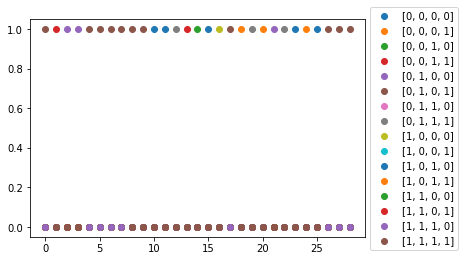

In [35]:
for i in range(len(windows_4)):
    plt.scatter(range(29),result_4[i],label=windows_4[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()